## Ordinary Differential Equations (ODEs)

In [152]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
# Get nicer looking plots than default
plt.style.use('bmh')
# Timer to measure the performance of methods
from time import time

### The Euler method

The example used here is:
$$ \frac{dy}{dt} = -y^2 $$

#### Forward Euler (explicit)
The forward Euler method is:

$$ y_{k+1} = y_k + \Delta t \left. \frac{dy}{dt} \right|_{k}, $$

which is equivalent to zero and first order terms in Taylor expansion. With our example, this becomes:

$$ y_{k+1} = y_k - \Delta t y_k^2. $$

#### Backward Euler (implicit)
The backward Euler method is:

$$ y_k = y_{k+1} - \Delta t \left. \frac{dy}{dt} \right|_{k+1}, $$

which in our example becomes:

$$ \Delta t y_{k+1}^2 + y_{k+1} -y_k = 0, $$

$$ y_{k+1} = \frac{1 \pm \sqrt{1 + 4\Delta t\, y_k}}{2\Delta t}. $$

We can see why this is called an implicit method: In the forward case, we get an explicit expression for $y_{k+1}$, while in the backward case, we must solve an equation (which depends on the system) to find $y_{k+1}$.

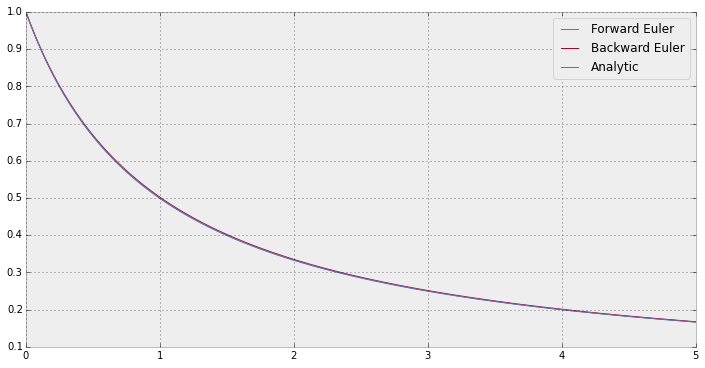

In [250]:
def dydt(t, y):
    return -y**2
    
def analytic(t):
    return 1/(t+1)

# Define variables
dt    = 0.01 # Timestep
T     = 5 # Max time
Nt    = int(T/dt) # Number of timesteps
yf    = np.zeros(Nt) # Array to hold y-values, forward (for plotting)
yb    = np.zeros(Nt) # Array to hold y-values, backward (for plotting)
yf[0] = 1 # Initial value
yb[0] = 1 # Initial value

# Loop over each timestep
for i in range(0, Nt-1):
    
    # Forward
    yf[i+1] = yf[i] - dt*yf[i]**2
    
    # Backward
    yb[i+1] = (-1 + np.sqrt(1+4*dt*yb[i])) / (2*dt)


fig = plt.figure(figsize = (12,6))
linewidth = 1
# Plot y-values as function of t
t = np.linspace(0, 5, Nt)
plt.plot(t, yf, label = 'Forward Euler', lw = linewidth)
plt.plot(t, yb, label = 'Backward Euler', lw = linewidth)
# Plot analytic solution with higher resolution in t
t = np.linspace(0, 5, 1000)
plt.plot(t, analytic(t), label = 'Analytic', lw = linewidth)
plt.legend()

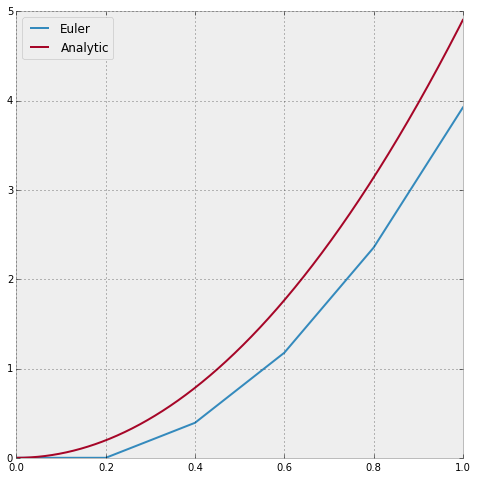

In [214]:
## Example problem: Falling in constant gravity

def v(t):
    g  = 9.81
    return g*t

def analytic(t):
    g  = 9.81
    return g*t**2/2

Tmax = 1
dt = 0.2
Nt = int(Tmax/dt)
T  = np.linspace(0, Tmax, Nt+1)
z  = np.zeros(Nt+1)

for i, t in enumerate(T[:-1]):
    z[i+1] = z[i] + dt*v(t) # t = dt*i
    
plt.figure(figsize = (8,8))
plt.plot(T, z, label = 'Euler')
T = np.linspace(0, Tmax, 1000)
plt.plot(T, analytic(T), label = 'Analytic')
plt.legend(loc = 'best')



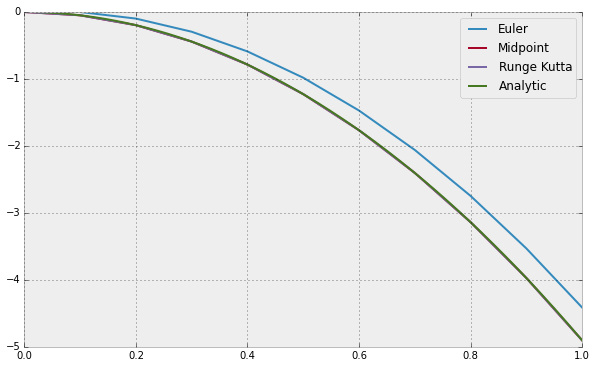

In [259]:
## Example problem: Falling in constant gravity

def v(t, z):
    g  = -9.81
    return g*t

def analytic(t):
    g  = -9.81
    return g*t**2/2

def forwardEuler(dt, t, y, dydt):
    return dt*dydt(t, y)

def midpoint(dt, t, z, dydt):
    return dt*dydt(t+dt/2, z+dt*dydt(t, z)/2)

def rungeKutta(dt, t, z, dydt):
    # f(t, z) = dz/dt = v(t)
    k1 = dydt(t, z)
    k2 = dydt(t + dt/2, z+dt*k1/2)
    k3 = dydt(t + dt/2, z+dt*k2/2)
    k4 = dydt(t + dt, z+dt*k3)
    return dt*(k1 + 2*k2 + 2*k3 + k4)/6

def falling(Tmax, dt, integrator):
    Nt = int(Tmax/dt)
    T  = np.linspace(0, Tmax, Nt+1)
    z  = np.zeros(Nt+1)
    for i, t in enumerate(T[:-1]):
        z[i+1] = z[i] + integrator(dt, t, z[i], v)
    return T, z
    
Tmax = 1
dt = 0.1
plt.figure(figsize = (10,6))

T, z = falling(Tmax, dt, forwardEuler)
plt.plot(T, z, label = 'Euler')

T, z = falling(Tmax, dt, midpoint)
plt.plot(T, z, label = 'Midpoint')

T, z = falling(Tmax, dt, rungeKutta)
plt.plot(T, z, label = 'Runge Kutta')

T = np.linspace(0, Tmax, 1000)
plt.plot(T, analytic(T), label = 'Analytic')
plt.legend(loc = 'best')


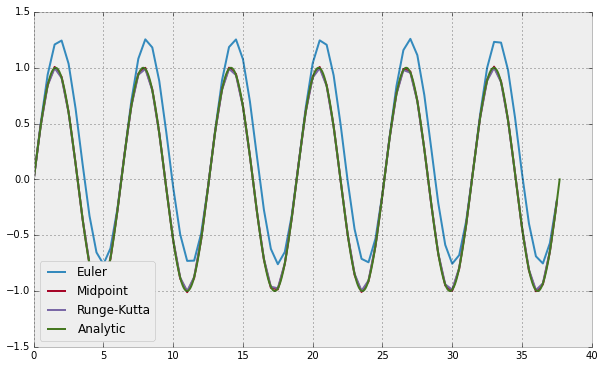

In [54]:
## Example problem: Sine

# dy/dt = cos(t) => y(t) = sin(t)

def v(t, z):
    return np.cos(t)

def analytic(t):
    return np.sin(t)

def forwardEuler(dt, t, z, dydt):
    return dt*dydt(t, z)

def midpoint(dt, t, z, dydt):
    return dt*dydt(t+dt/2, z+dt*dydt(t, z)/2)

def rungeKutta(dt, t, z, dydt):
    # f(t, z) = dz/dt = v(t)
    k1 = dydt(t, z)
    k2 = dydt(t + dt/2, z+dt*k1/2)
    k3 = dydt(t + dt/2, z+dt*k2/2)
    k4 = dydt(t + dt, z+dt*k3)
    return dt*(k1 + 2*k2 + 2*k3 + k4)/6

def integrate(Tmax, dt, integrator):
    T  = np.arange(0, Tmax, dt)
    z  = np.zeros(len(T))
    for i in range(len(T)-1):
        t = i*dt
        z[i+1] = z[i] + integrator(dt, t, z[i], v)
    return T, z
    
Tmax = 12*np.pi
dt = 0.5
plt.figure(figsize = (10,6))

T, z = integrate(Tmax, dt, forwardEuler)
plt.plot(T, z, label = 'Euler')

T, z = integrate(Tmax, dt, midpoint)
plt.plot(T, z, label = 'Midpoint')

T, z = integrate(Tmax, dt, rungeKutta)
plt.plot(T, z, label = 'Runge-Kutta')

T = np.linspace(0, Tmax, 1000)
plt.plot(T, analytic(T), label = 'Analytic')
plt.legend(loc = 'best')


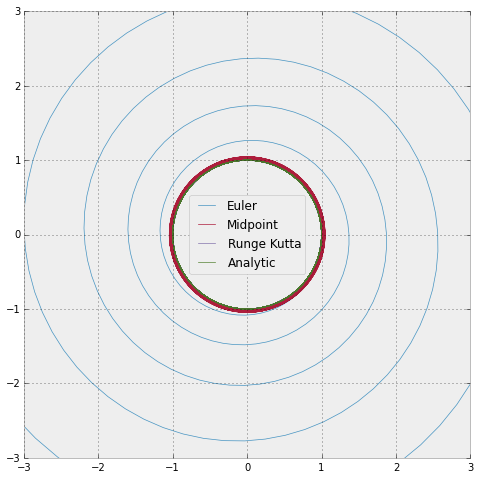

In [53]:
## Example problem: Circular orbit in magnetic field

def dvdt(t, v):
    q = 1
    m = 1
    B = np.array([0., 0., 1.])
    return q*np.cross(v, B)/m

def analytic(t):
    v = np.zeros((3, len(t)))
    v[0,:] = np.cos(t)
    v[1,:] = -np.sin(t)
    return v

def forwardEuler(dt, t, z, dydt):
    return dt*dydt(t, z)

def midpoint(dt, t, z, dydt):
    return dt*dydt(t+dt/2, z+dt*dydt(t, z)/2)

def rungeKutta(dt, t, z, dydt):
    # f(t, z) = dz/dt = v(t)
    k1 = dydt(t, z)
    k2 = dydt(t + dt/2, z+dt*k1/2)
    k3 = dydt(t + dt/2, z+dt*k2/2)
    k4 = dydt(t + dt, z+dt*k3)
    return dt*(k1 + 2*k2 + 2*k3 + k4)/6

def integrate(Tmax, dt, integrator):
    T  = np.arange(0, Tmax, dt)
    v  = np.zeros((3, len(T)))
    # Initial velocity
    v[:,0] = [1., 0., 0.]
    for i in range(len(T)-1):
        t = i*dt
        v[:,i+1] = v[:,i] + integrator(dt, t, v[:,i], dvdt)
    return T, v
    
Tmax = 120*np.pi
dt = 0.1
plt.figure(figsize = (8,8))
lim = 3
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

linewidth = 0.7
alpha = 0.9

T, v = integrate(Tmax, dt, forwardEuler)
plt.plot(v[0,:], v[1,:], label = 'Euler', lw = linewidth, alpha = alpha)

T, v = integrate(Tmax, dt, midpoint)
plt.plot(v[0,:], v[1,:], label = 'Midpoint', lw = linewidth, alpha = alpha)

T, v = integrate(Tmax, dt, rungeKutta)
plt.plot(v[0,:], v[1,:], label = 'Runge Kutta', lw = linewidth, alpha = alpha)

T = np.linspace(0, Tmax, 100000)
v = analytic(T)
plt.plot(v[0,:], v[1,:], label = 'Analytic', lw = linewidth, alpha = alpha)
plt.legend(loc = 'best')

In [264]:
## Example problem: Satellite orbit

def g(r):
    # Function to calculate acceleration of gravity
    # Mass Earth
    M  = 5.972e24
    # Gravitational constant
    G  = 6.67e-11
    
    # Magnitude of g
    mg = G*M/np.sum(r**2)
    # radius of orbit
    L  = np.sqrt(np.sum(r**2))
    
    # x and y components
    gx = -mg*r[0]/L
    gy = -mg*r[1]/L
    
    # return as an array for convenient calculations
    return np.array([gx, gy])


def orbiter(T, dt, integrator):    
    # Initial conditions, data corresponds
    # to geosyncronous orbit
    r = np.array([42.164e6, 0.0])
    v = np.array([0.0, 3.07e3])

    # Number of timesteps
    Nt = int(T/dt)

    # Array to hold positions for plotting
    X  = np.zeros((2, Nt+1))
    X[:,0] = r

    # Loop over timesteps
    for i in range(1, Nt+1):
        v += dt*g(r)
        r += dt*v
        X[:,i] = r
    return X
    

In [265]:
X = orbiter(T, dt, None)
fig = plt.figure(figsize = (6,6))
plt.plot(X[0,:], X[1,:], lw = 0.5)

TypeError: only length-1 arrays can be converted to Python scalars

In [266]:
def orbiter(T, dt, integrator):    
    # Initial conditions, data corresponds
    # to geosyncronous orbit
    r = np.array([42.164e6, 0.0])
    v = np.array([0.0, 3.07e3])

    # Number of timesteps
    Nt = int(T/dt)

    # Array to hold positions for plotting
    X  = np.zeros((2, Nt+1))
    X[:,0] = r

    # Loop over timesteps
    for i in range(1, Nt+1):
        v += integrator(dt, r, g)
        r += dt*v
        X[:,i] = r
    return X

## Shooting method

#### Example:

$$ \frac{\mathrm{d}^2 y}{\mathrm{d}x^2} = y - \frac{xy}{5} + x $$

$$ y(1) = 2, \;\; y(3) = -1 $$

/Users/nordam/.virtualenvs/default/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


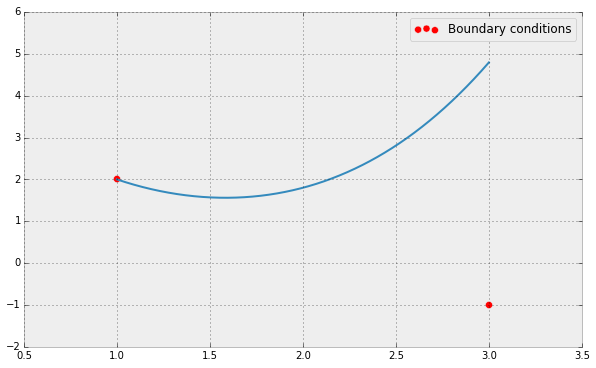

In [267]:
# Example

def ddyddx(y, x):
    return y - x*y/5 + x

# Guess at a value of dy/dx at x=1
# y(t) goes down from 2 to -1, so we guess that 
# dy/dx = -1.5 at x=1, since this is the average slope
dydx = -1.5
# Array of values
N  = 1000
X  = np.linspace(1, 3, N)
Y  = np.zeros(N)
# Initial value
Y[0] = 2
dx = X[1] - X[0]

for i, x in enumerate(X[:-1]):
    dydx  += ddyddx(Y[i], x)*dx
    Y[i+1] = Y[i] + dydx*dx
    
fig = plt.figure(figsize = (10,6))
plt.plot(X, Y)
plt.scatter([1,3], [2, -1], marker = 'o', c = 'r', s = 50, label = 'Boundary conditions')
plt.legend(loc = 'best')

/Users/nordam/.virtualenvs/default/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


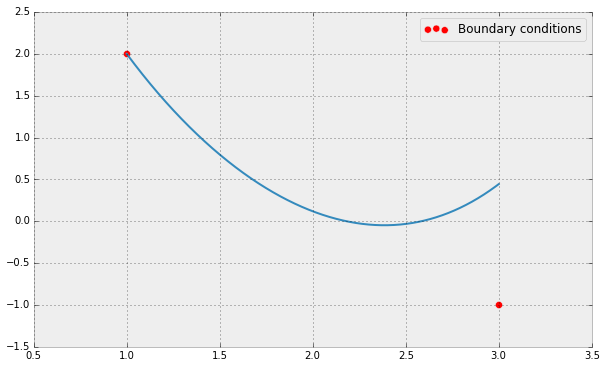

In [268]:
# Example

def ddyddx(y, x):
    return y - x*y/5 + x

# Guess at a value of dy/dx at x=1
# y(t) goes down from 2 to -1, so we guess that 
# dy/dx = -1.5 at x=1, since this is the average slope
dydx = -3
# Array of values
N  = 1000
X  = np.linspace(1, 3, N)
Y  = np.zeros(N)
# Initial value
Y[0] = 2
dx = X[1] - X[0]

for i, x in enumerate(X[:-1]):
    dydx  += ddyddx(Y[i], x)*dx
    Y[i+1] = Y[i] + dydx*dx
    
fig = plt.figure(figsize = (10,6))
plt.plot(X, Y)
plt.scatter([1,3], [2, -1], marker = 'o', c = 'r', s = 50, label = 'Boundary conditions')
plt.legend(loc = 'best')

/Users/nordam/.virtualenvs/default/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


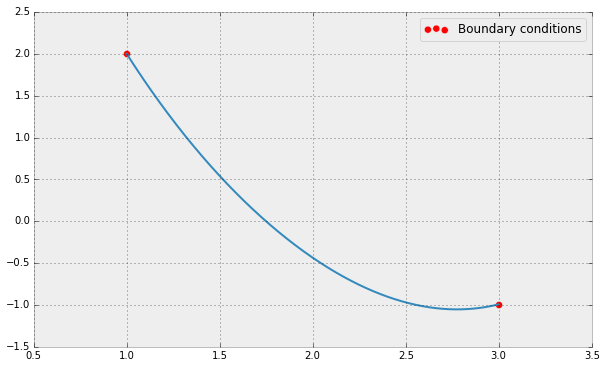

In [269]:
# Example

def ddyddx(y, x):
    return y - x*y/5 + x


# Calculate new initial value of dydx by linear
# extrapolation from the two previous guesses

# dydx | y(3)
# -1.5 | 4.78
# -3.0 | 0.43

# Equation for dydx(1) as function of y(3) is:
# dydx(1) = a*y(3) + b, where
# a = (-3 - (-1.5)) / (0.43 - 4.78) = 0.345
# b = -(3 + 0.43*a) = -3.15
# 
# Inserting y(3) = -1, we get
# dydx(1) = 0.345*(-1) - 3.15 = -3.495

dydx = -3.495

# Array of values
N  = 1000
X  = np.linspace(1, 3, N)
Y  = np.zeros(N)
# Initial value
Y[0] = 2
dx = X[1] - X[0]

for i, x in enumerate(X[:-1]):
    dydx  += ddyddx(Y[i], x)*dx
    Y[i+1] = Y[i] + dydx*dx
    
fig = plt.figure(figsize = (10,6))
plt.plot(X, Y)
plt.scatter([1,3], [2, -1], marker = 'o', c = 'r', s = 50, label = 'Boundary conditions')
plt.legend(loc = 'best')

In [275]:
for i, x in enumerate(np.linspace(0, 1, 10)):
    print(i, x)

0 0.0
1 0.111111111111
2 0.222222222222
3 0.333333333333
4 0.444444444444
5 0.555555555556
6 0.666666666667
7 0.777777777778
8 0.888888888889
9 1.0


In [276]:
i = 0
for x in np.linspace(0, 1, 10):
    print(i, x)
    i += 1

0 0.0
1 0.111111111111
2 0.222222222222
3 0.333333333333
4 0.444444444444
5 0.555555555556
6 0.666666666667
7 0.777777777778
8 0.888888888889
9 1.0


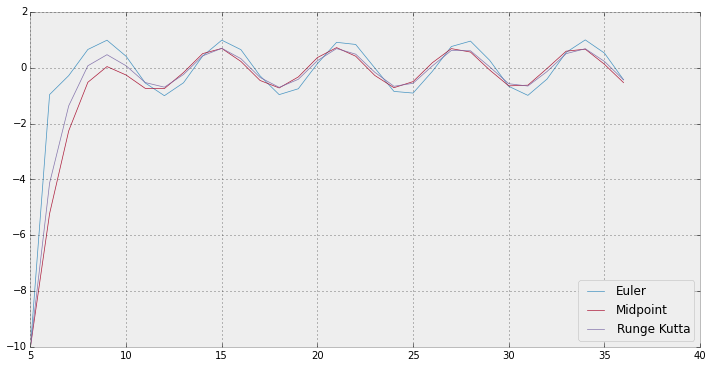

In [286]:
# Example, eq 1.1 from Griffiths and Higham

def dxdt(t, x):
    return np.sin(t) - x

def forwardEuler(dt, t, z, dydt):
    return dt*dydt(t, z)

def midpoint(dt, t, z, dydt):
    return dt*dydt(t+dt/2, z+dt*dydt(t, z)/2)

def rungeKutta(dt, t, z, dydt):
    # f(t, z) = dz/dt = v(t)
    k1 = dydt(t, z)
    k2 = dydt(t + dt/2, z+dt*k1/2)
    k3 = dydt(t + dt/2, z+dt*k2/2)
    k4 = dydt(t + dt, z+dt*k3)
    return dt*(k1 + 2*k2 + 2*k3 + k4)/6

def integrate(Tmax, dt, integrator):
    T  = np.arange(0, Tmax, dt)
    X  = np.zeros(len(T))
    # Initial x and t
    X[0] = -10
    T += 5
    for i in range(len(T)-1):
        X[i+1] = X[i] + integrator(dt, T[i], X[i], dxdt)
    return T, X

Tmax = 10*np.pi
dt = 1.0
plt.figure(figsize = (12,6))

linewidth = 0.7
alpha = 0.9

T, X = integrate(Tmax, dt, forwardEuler)
plt.plot(T, X, label = 'Euler', lw = linewidth, alpha = alpha)

T, X = integrate(Tmax, dt, midpoint)
plt.plot(T, X, label = 'Midpoint', lw = linewidth, alpha = alpha)

T, X = integrate(Tmax, dt, rungeKutta)
plt.plot(T, X, label = 'Runge Kutta', lw = linewidth, alpha = alpha)

plt.legend(loc = 'best')

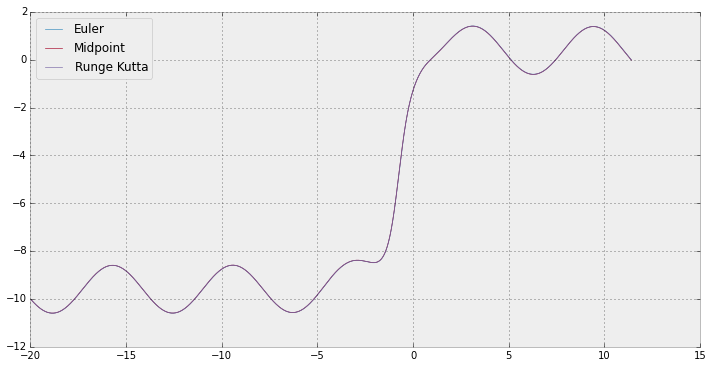

In [291]:
# Example 1.2 from Griffiths and Higham

def dxdt(t, x):
    return np.sin(t) - 2*x/(1+t**4)

def forwardEuler(dt, t, z, dydt):
    return dt*dydt(t, z)

def midpoint(dt, t, z, dydt):
    return dt*dydt(t+dt/2, z+dt*dydt(t, z)/2)

def rungeKutta(dt, t, z, dydt):
    # f(t, z) = dz/dt = v(t)
    k1 = dydt(t, z)
    k2 = dydt(t + dt/2, z+dt*k1/2)
    k3 = dydt(t + dt/2, z+dt*k2/2)
    k4 = dydt(t + dt, z+dt*k3)
    return dt*(k1 + 2*k2 + 2*k3 + k4)/6

def integrate(Tmax, dt, integrator):
    T  = np.arange(0, Tmax, dt)
    X  = np.zeros(len(T))
    # Initial x and t
    X[0] = -10
    T -= 20
    for i in range(len(T)-1):
        X[i+1] = X[i] + integrator(dt, T[i], X[i], dxdt)
    return T, X

Tmax = 10*np.pi
dt = 0.01
plt.figure(figsize = (12,6))

linewidth = 0.7
alpha = 0.9

T, X = integrate(Tmax, dt, forwardEuler)
plt.plot(T, X, label = 'Euler', lw = linewidth, alpha = alpha)

T, X = integrate(Tmax, dt, midpoint)
plt.plot(T, X, label = 'Midpoint', lw = linewidth, alpha = alpha)

T, X = integrate(Tmax, dt, rungeKutta)
plt.plot(T, X, label = 'Runge Kutta', lw = linewidth, alpha = alpha)

plt.legend(loc = 'best')

In [49]:
## Example problem: N-body gravitational problem

def g(r, M):
    # Function to calculate acceleration of gravity
    # on mass m, due to mass M
    # Takes vector from m to M, and mass of M
    
    # Gravitational constant
    G = 2
    # Magnitude of g
    mg = G*M/np.sum(r**2)
    # radius of orbit
    L  = np.sqrt(np.sum(r**2))
    
    # x and y components
    gx = mg*r[0]/L
    gy = mg*r[1]/L
    
    # return as an array for convenient calculations
    return np.array([gx, gy])

def energy(X, V, M):
    N = len(M)
    # Total kinetic energy:
    Ek = 0.5*np.sum((V[:,0]**2 + V[:,1]**2)*M[:])
    # Total potential energy:
    Ep = 0.0
    for i in range(N):
        for j in range(i):
            r = X[j] - X[i]
            L  = np.sqrt(np.sum(r**2))
            Ep += L*M[i]*np.sqrt(np.sum(g(r, M[j])**2))
    return Ek + Ep

def orbiter(N):
    # Random initial conditions
    X = 1*(2*np.random.random((N, 2)) - 1)
    V = 0.1*(2*np.random.random((N, 2)) - 1)
    M = np.random.random(N)

    # Timestep
    dt = 1e-4
    T  = 10
    
    # Hold positions for later plotting
    Nt = int(T/dt)
    P  = np.zeros((Nt, N, 2))
    
    # Hold energy
    E = np.zeros(Nt)
    
    for t in range(Nt):
        # Array to hold acceleration, set to zero at each step
        A = np.zeros((N, 2))

        # Loop over each planet
        for i in range(N):
            # Calculate force from each other planet:
            for j in range(N):
                # No force from itself
                if i != j:
                    A[i,:] += g(X[j,:] - X[i,:], M[j])
                
            V[i,:] += A[i,:]*dt
            X[i,:] += V[i,:]*dt
            
        P[t,:,:] = X[:,:]
        E[t] = energy(X, V, M)
    return P, E

(-2, 2)

/Users/nordam/.virtualenvs/default/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


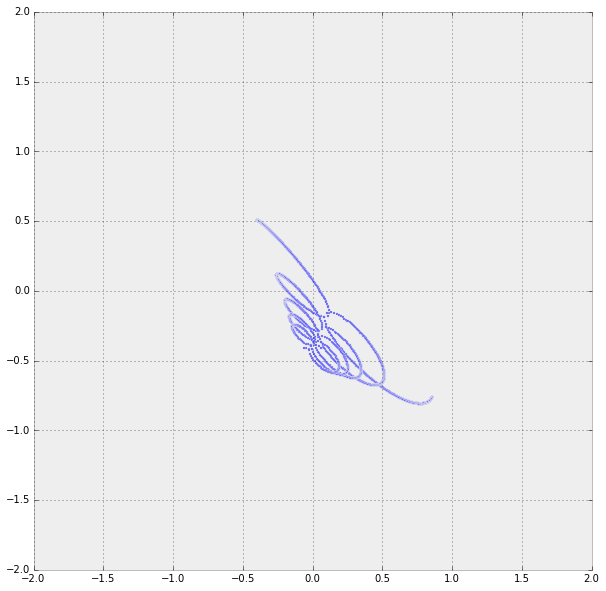

In [51]:
N = 2
P, E = orbiter(N)
step = 100
fig = plt.figure(figsize = (10, 10))
for i in range(N):
    plt.scatter(P[::step,i,0], P[::step,i,1], marker = '.')
plt.xlim(-2, 2)
plt.ylim(-2, 2)

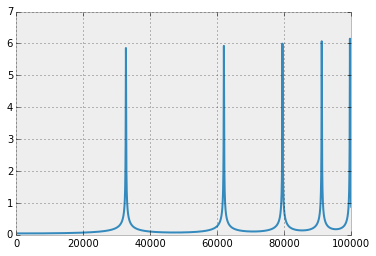

In [52]:
plt.plot(E)

/Users/nordam/.virtualenvs/default/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


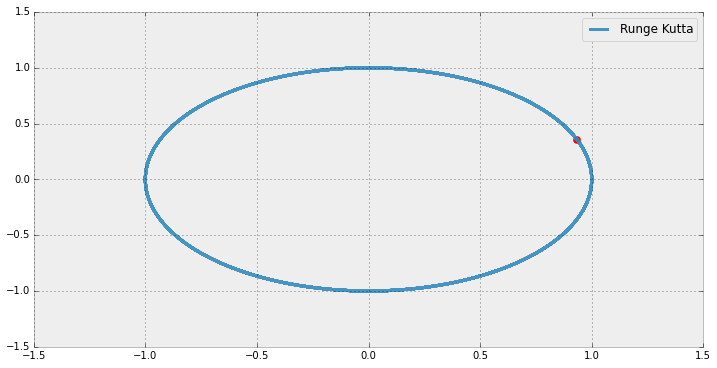

In [106]:
## Example problem: Circular orbit in magnetic field

def B(t, x):
    #return x[1]**2*np.array([0., 0., 1.])
    return np.array([0., 0., 1.])

def f(t, y, z):
    return z

def g(t, y, z):
    q = 1
    m = 1
    return q*np.cross(z, B(t, y))/m

def rungeKutta(h, t, y, z, f, g):
    k1 = f(t, y, z)
    l1 = g(t, y, z)
    k2 = f(t + h/2, y+h*k1/2, z+h*l1/2)
    l2 = g(t + h/2, y+h*k1/2, z+h*l1/2)
    k3 = f(t + h/2, y+h*k2/2, z+h*l2/2)
    l3 = g(t + h/2, y+h*k2/2, z+h*l2/2)
    k4 = f(t + h,   y+h*k3,   z+h*l3)
    l4 = g(t + h,   y+h*k3,   z+h*l3)
    y_new = y + h*(k1 + 2*k2 + 2*k3 + k4)/6
    z_new = z + h*(l1 + 2*l2 + 2*l3 + l4)/6
    return y_new, z_new

def integrate(Tmax, h, integrator):
    T  = np.arange(0, Tmax, h)
    X  = np.zeros((len(T), 3))
    V  = np.zeros((len(T), 3))
    # Initial values
    x  = np.array([0., 1., 0.])
    v  = np.array([1., 0., 0.])
    # Mapping to new variables, y and z:
    # y = x
    # z = v
    for i in range(len(T)):
        t = i*h
        x, v = integrator(h, t, x, v, f, g)
        X[i, :] = x[:]
        V[i, :] = v[:]
    return T, X, V
    
Tmax = 24*np.pi
h    = 1e-2
plt.figure(figsize = (12,6))

linewidth = 3
alpha = 0.9

T, X, V = integrate(Tmax, h, rungeKutta)
plt.plot(X[:,0], X[:,1], label = 'Runge Kutta', lw = linewidth, alpha = alpha)
plt.scatter(X[120,0], X[120,1], color = 'r', s = 50)

plt.legend(loc = 'best')

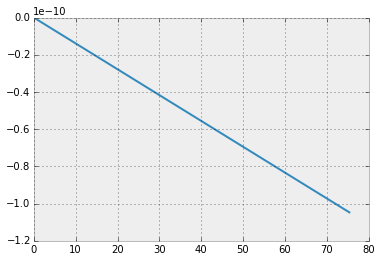

In [107]:
# Check conservation of energy
# Plot E(t)/E(t=0) - 1

E0 = 0.5*(V[0,0]**2+V[0,1]**2+V[0,2]**2)
plt.plot(T, 0.5*(V[:,0]**2+V[:,1]**2+V[:,2]**2)/E0-1)

Runge-Kutta, steps:  646 time:  0.7045638561248779
Forward Euler, steps:  80920 time:  19.683366060256958


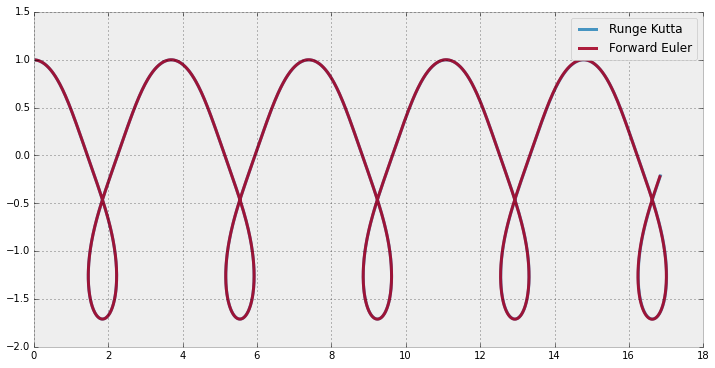

In [154]:
## Example problem: Circular orbit in magnetic field

def B(t, x):
    return x[1]**2*np.array([0., 0., 1.])
    #return np.array([0., 0., 1.])

def f(t, y, z):
    return z

def g(t, y, z):
    q = 1
    m = 1
    return q*np.cross(z, B(t, y))/m

def forwardEuler(h, t, y, z, f, g):
    k1 = f(t, y, z)
    l1 = g(t, y, z)
    y_new = y + h*k1
    z_new = z + h*l1
    return y_new, z_new

def rungeKutta(h, t, y, z, f, g):
    k1 = f(t, y, z)
    l1 = g(t, y, z)
    k2 = f(t + h/2, y+h*k1/2, z+h*l1/2)
    l2 = g(t + h/2, y+h*k1/2, z+h*l1/2)
    k3 = f(t + h/2, y+h*k2/2, z+h*l2/2)
    l3 = g(t + h/2, y+h*k2/2, z+h*l2/2)
    k4 = f(t + h,   y+h*k3,   z+h*l3)
    l4 = g(t + h,   y+h*k3,   z+h*l3)
    y_new = y + h*(k1 + 2*k2 + 2*k3 + k4)/6
    z_new = z + h*(l1 + 2*l2 + 2*l3 + l4)/6
    return y_new, z_new

def stepper(h, t, x, v, f, g, integrator):
    # Step once, with stepsize h
    x1, v1 = integrator(h, t, x, v, f, g)
    # Step twice, with stepsize h/2
    x2, v2 = integrator(h/2, t, x, v, f, g)
    x2, v2 = integrator(h/2, t, x2, v2, f, g)
    # calculate error
    
    err = np.linalg.norm(x2-x1)/np.linalg.norm(x2)
    # Return x2, v2, which are presumable more accurate
    return x2, v2, err

def variableIntegrate(Tmax, h0, tol, integrator):
    T  = []
    X  = []
    V  = []
    # Initial values
    x  = np.array([0., 1., 0.])
    v  = np.array([1., 0., 0.])
    # Mapping to new variables, y and z:
    # y = x
    # z = v
    
    # Start at time 0, with initial guess of stepsize
    t = 0
    h = h0
    while t < Tmax:
        T.append(t)
        flag = True
        while flag:
            x1, v1, err = stepper(h, t, x, v, f, g, integrator)
            if err > tol:
                h = h/2
            else:
                t += h
                h = 1.5*h
                x = x1
                v = v1
                flag = False
        X.append(x)
        V.append(v)
    T = np.array(T)
    X = np.array(X)
    V = np.array(V)
    return T, X, V
    
Tmax = 12*np.pi
h0   = 1e-2
tol  = 1e-8

# Figure parameters
plt.figure(figsize = (12,6))
linewidth = 3
alpha = 0.9

tic = time()
T, X, V = variableIntegrate(Tmax, h0, tol, rungeKutta)
toc = time()
print('Runge-Kutta, steps: ', len(T), 'time: ', toc - tic)
plt.plot(X[:,0], X[:,1], label = 'Runge Kutta', lw = linewidth, alpha = alpha)

tic = time()
T, X, V = variableIntegrate(Tmax, h0, tol, forwardEuler)
toc = time()
print('Forward Euler, steps: ', len(T), 'time: ', toc - tic)
plt.plot(X[:,0], X[:,1], label = 'Forward Euler', lw = linewidth, alpha = alpha)


plt.legend(loc = 'best')

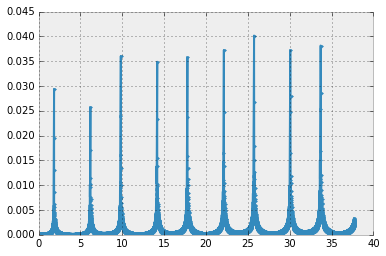

In [155]:
plt.plot(T[1:], T[1:]-T[:-1], marker = '.')

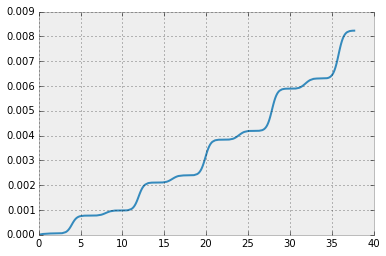

In [156]:
# Check conservation of energy
# Plot E(t)/E(t=0) - 1

E0 = 0.5*(V[0,0]**2+V[0,1]**2+V[0,2]**2)
plt.plot(T, 0.5*(V[:,0]**2+V[:,1]**2+V[:,2]**2)/E0-1)